# Human Activity Recognition with Hidden Markov Models

This notebook builds a compact end-to-end pipeline to recognize four activities — **standing, walking, jumping, still** — from smartphone inertial data.  



In [1]:
# Imports & setup (single cell)
import sys
import os
from pathlib import Path
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

# project root so we can import our simple modules
ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
if ROOT not in sys.path:
    sys.path.append(ROOT)

# simple modules (functions only)
from src.config import TARGET_HZ, EDGE_TRIM_SEC, MERGE_TOL_SEC
from src.data_loader import unpack_and_clean_dir, read_split_activity, estimate_hz_csv, duration_seconds_csv




## 1 — Data Acquisition & Cleaning

### 1.1 — Inventory & naming convention
We first list the zipped recordings and verify the expected pattern:  
`setA|setB_<Activity>_<Index>-YYYY-MM-DD_HH-MM-SS.zip`  
Activities expected: **standing, walking, jumping, still**.


In [2]:
train_raw = os.path.join(ROOT, "data", "raw", "train")
test_raw  = os.path.join(ROOT, "data", "raw", "test")

train_zips = sorted([os.path.join(train_raw, f) for f in os.listdir(train_raw) if f.endswith(".zip")])
test_zips  = sorted([os.path.join(test_raw,  f) for f in os.listdir(test_raw)  if f.endswith(".zip")])

print(f"Found {len(train_zips)} train zips and {len(test_zips)} test zips.")
print("Train sample:", [os.path.basename(p) for p in train_zips[:3]])
print("Test sample:",  [os.path.basename(p) for p in test_zips[:3]])


Found 52 train zips and 12 test zips.
Train sample: ['setA_Jumping_1-2025-10-25_13-52-04.zip', 'setA_Jumping_10-2025-10-25_14-00-15.zip', 'setA_Jumping_11-2025-10-25_14-06-37.zip']
Test sample: ['setB_Jumping_1-2025-10-24_15-15-26.zip', 'setB_Jumping_2-2025-10-24_15-16-46.zip', 'setB_Jumping_3-2025-10-24_15-18-46.zip']


### 1.2 — Unpack & standardize sensor files
For each zip:
1) Read accelerometer and gyroscope CSVs  
2) Normalize the time axis to seconds-from-start and axis names to x/y/z  
3) Drop duplicate timestamps, sort by time


In [3]:
train_out = os.path.join(ROOT, "data", "processed", "train")
test_out  = os.path.join(ROOT, "data", "processed", "test")

print("Cleaning TRAIN…")
unpack_and_clean_dir(train_raw, train_out)

print("Cleaning TEST…")
unpack_and_clean_dir(test_raw, test_out)


Cleaning TRAIN…
Cleaning TEST…


In [4]:
clean_train = sorted([os.path.join(train_out, f) for f in os.listdir(train_out) if f.endswith("_cleaned.csv")])
clean_test  = sorted([os.path.join(test_out,  f) for f in os.listdir(test_out)  if f.endswith("_cleaned.csv")])

print(f"Cleaned CSVs → train: {len(clean_train)}, test: {len(clean_test)}")


Cleaned CSVs → train: 52, test: 12


### 1.3 — Harmonize sampling rate
Phones may log at slightly different rates. We resample to a **uniform 100 Hz** grid so windows and features are comparable across recordings and devices.


In [5]:
def estimate_hz(time_s_series):
    t = time_s_series.to_numpy()
    if len(t) < 2: 
        return float("nan")
    dt = t[1:] - t[:-1]
    dt = dt[dt > 0]
    return float(1.0 / pd.Series(dt).median()) if len(dt) else float("nan")

samples = (clean_train[:2] + clean_test[:2])[:4]
for p in samples:
    df = pd.read_csv(p, usecols=["time_s"])
    hz = estimate_hz(df["time_s"])
    print(f"{os.path.basename(p):50s}  ~{hz:.1f} Hz (target={TARGET_HZ})")


setA_Jumping_1-2025-10-25_13-52-04_cleaned.csv      ~100.0 Hz (target=100)
setA_Jumping_10-2025-10-25_14-00-15_cleaned.csv     ~100.0 Hz (target=100)
setB_Jumping_1-2025-10-24_15-15-26_cleaned.csv      ~100.0 Hz (target=100)
setB_Jumping_2-2025-10-24_15-16-46_cleaned.csv      ~100.0 Hz (target=100)


### 1.4 — Merge sensors & trim edges
We align accelerometer and gyroscope by nearest timestamp (≈10 ms tolerance), then trim **1.0 s** at both ends to remove “start/stop” noise added during recording


In [6]:
if clean_train:
    df = pd.read_csv(clean_train[0])
    first_t = float(df["time_s"].iloc[0])
    last_t  = float(df["time_s"].iloc[-1])
    have_cols = all(c in df.columns for c in ["ax","ay","az","gx","gy","gz"])
    print(f"First time_s: {first_t:.3f} s  (expected ≈ {EDGE_TRIM_SEC} s)")
    print(f"Last  time_s: {last_t:.3f} s")
    print("Accel+Gyro columns present:", have_cols)


First time_s: 2.000 s  (expected ≈ 2.0 s)
Last  time_s: 12.570 s
Accel+Gyro columns present: True


### 1.5 — Save cleaned recordings
We verify the number of cleaned files per split and preview the first few rows of one cleaned CSV to confirm schema and values.


In [7]:
print(f"Cleaned CSVs → train: {len(clean_train)}, test: {len(clean_test)}")
if clean_train:
    ex = clean_train[0]
    print("Train example file:", os.path.basename(ex))
    df_preview = pd.read_csv(ex)
    display(df_preview.head(8))
    print("Columns:", list(df_preview.columns))


Cleaned CSVs → train: 52, test: 12
Train example file: setA_Jumping_1-2025-10-25_13-52-04_cleaned.csv


,time_s,ax,ay,az,gx,gy,gz,activity,split,recording_id
0,2.00,15.804578,0.128842,-7.118369,4.240118,1.296773,3.034824,jumping,train,1
1,2.01,13.679525,-2.315727,-18.604221,0.867119,-0.282600,0.290278,jumping,train,1
2,2.02,9.968347,-6.921781,-15.721929,0.867119,-0.282600,0.290278,jumping,train,1
3,2.03,3.632270,-15.104903,10.938396,0.781551,-2.902326,0.030360,jumping,train,1
4,2.04,-5.302757,-22.740102,22.707943,0.799704,-1.333761,0.261616,jumping,train,1
5,2.05,-18.854027,-29.402079,8.028546,0.430737,1.277171,0.788246,jumping,train,1
6,2.06,-30.376551,-34.871930,-0.225002,0.154265,2.984646,2.148753,jumping,train,1
7,2.07,-38.041065,-38.074748,3.741309,0.542334,5.333729,5.232357,jumping,train,1


Columns: ['time_s', 'ax', 'ay', 'az', 'gx', 'gy', 'gz', 'activity', 'split', 'recording_id']


## 2 — Device & Sampling Metadata

### 2.1 — Device table (fill in and display)
We record the devices used and their intended sampling rates.  
Fill the rows below (add/remove as needed), then we’ll verify the **empirical** rates from the cleaned files.


In [8]:
device_rows = [
    {"member": "Christian B.", "phone": "Android Pixel", "target_hz": TARGET_HZ, "notes": "Front pocket (screen out, upside-down)"},
    {"member": "Reponse I.", "phone": "Iphone 15", "target_hz": TARGET_HZ, "notes": "Back pocket (screen in, upright)"},
]
device_df = pd.DataFrame(device_rows, columns=["member","phone","target_hz","notes"])
display(device_df)


,member,phone,target_hz,notes
0,Christian B.,Android Pixel,100,"Front pocket (screen out, upside-down)"
1,Reponse I.,Iphone 15,100,"Back pocket (screen in, upright)"


### 2.2 — Harmonization plan
Phones can log slightly above/below the target rate.  
We resample each stream to a **uniform 100 Hz** grid during cleaning so windows/features are comparable across recordings and devices.  
Next, we verify this by **estimating the empirical Hz per cleaned file**.

We compute an empirical sampling rate for each cleaned file (median Δt⁻¹) and summarize by split/activity.


In [9]:
def estimate_hz_from_csv(path_csv):
    s = pd.read_csv(path_csv, usecols=["time_s"])
    t = s["time_s"].to_numpy()
    if len(t) < 2:
        return float("nan")
    dt = t[1:] - t[:-1]
    dt = dt[dt > 0]
    return float(1.0 / pd.Series(dt).median()) if len(dt) else float("nan")

def read_activity_quick(path_csv):
    s = pd.read_csv(path_csv, usecols=["activity","split"], nrows=1)
    return s["split"].iloc[0], s["activity"].iloc[0]


In [10]:
rows = []
for p in clean_train + clean_test:
    split, activity = read_activity_quick(p)
    hz = estimate_hz_from_csv(p)
    rows.append({"file": os.path.basename(p), "split": split, "activity": activity, "empirical_hz": round(hz, 2)})

hz_df = pd.DataFrame(rows).sort_values(["split","activity","file"]).reset_index(drop=True)
display(hz_df.head(10))

,file,split,activity,empirical_hz
0,setB_Jumping_1-2025-10-24_15-15-26_cleaned.csv,test,jumping,100.0
1,setB_Jumping_2-2025-10-24_15-16-46_cleaned.csv,test,jumping,100.0
2,setB_Jumping_3-2025-10-24_15-18-46_cleaned.csv,test,jumping,100.0
3,setB_Standing_1-2025-10-26_13-29-15_cleaned.csv,test,standing,100.0
4,setB_Standing_2-2025-10-26_13-28-55_cleaned.csv,test,standing,100.0
5,setB_Standing_3-2025-10-26_13-28-35_cleaned.csv,test,standing,100.0
6,setB_Still_1-2025-10-26_13-27-04_cleaned.csv,test,still,100.0
7,setB_Still_2-2025-10-26_13-26-43_cleaned.csv,test,still,100.0
8,setB_Still_3-2025-10-26_13-26-24_cleaned.csv,test,still,100.0
9,setB_Walking_1-2025-10-24_15-11-38_cleaned.csv,test,walking,100.0


### 2.4 — Summary by split and activity
We expect empirical rates to cluster tightly around the target (≈100 Hz) for **both** train and test, across all activities.


In [11]:
summary = (hz_df
           .groupby(["split","activity"], as_index=False)
           .agg(n=("empirical_hz","size"),
                hz_median=("empirical_hz","median"),
                hz_min=("empirical_hz","min"),
                hz_max=("empirical_hz","max")))
display(summary)

,split,activity,n,hz_median,hz_min,hz_max
0,test,jumping,3,100.0,100.0,100.0
1,test,standing,3,100.0,100.0,100.0
2,test,still,3,100.0,100.0,100.0
3,test,walking,3,100.0,100.0,100.0
4,train,jumping,13,100.0,100.0,100.0
5,train,standing,13,100.0,100.0,100.0
6,train,still,13,100.0,100.0,100.0
7,train,walking,13,100.0,100.0,100.0


## 3 — Data Analysis

### 3.1 — Counts by split and activity
We check that each split (train/test) contains all four activities and roughly balanced counts.


In [12]:
rows = []
for p in clean_train + clean_test:
    split, activity = read_split_activity(p)
    rows.append({"file": os.path.basename(p), "split": split, "activity": activity})

sa_df = pd.DataFrame(rows)
counts = sa_df.groupby(["split","activity"]).size().reset_index(name="n_files")
display(counts.sort_values(["split","activity"]))


,split,activity,n_files
0,test,jumping,3
1,test,standing,3
2,test,still,3
3,test,walking,3
4,train,jumping,13
5,train,standing,13
6,train,still,13
7,train,walking,13


### 3.2 — Duration per recording
Each recording should be roughly **5–10 seconds** after edge trimming.  
We compute per-file duration and summarize by split and activity.


In [13]:
dur_rows = []
for p in clean_train + clean_test:
    split, activity = read_split_activity(p)
    dur = duration_seconds_csv(p)
    dur_rows.append({
        "file": os.path.basename(p),
        "split": split,
        "activity": activity,
        "duration_s": round(dur, 2)
    })

dur_df = pd.DataFrame(dur_rows)
display(dur_df.head(10))

summary_dur = (dur_df
               .groupby(["split","activity"], as_index=False)
               .agg(n=("duration_s","size"),
                    dur_median=("duration_s","median"),
                    dur_min=("duration_s","min"),
                    dur_max=("duration_s","max")))
display(summary_dur.sort_values(["split","activity"]))


,file,split,activity,duration_s
0,setA_Jumping_1-2025-10-25_13-52-04_cleaned.csv,train,jumping,10.57
1,setA_Jumping_10-2025-10-25_14-00-15_cleaned.csv,train,jumping,16.34
2,setA_Jumping_11-2025-10-25_14-06-37_cleaned.csv,train,jumping,12.28
3,setA_Jumping_12-2025-10-25_14-05-59_cleaned.csv,train,jumping,17.04
4,setA_Jumping_13-2025-10-25_14-05-22_cleaned.csv,train,jumping,11.59
5,setA_Jumping_2-2025-10-25_13-52-34_cleaned.csv,train,jumping,12.34
6,setA_Jumping_3-2025-10-25_13-53-05_cleaned.csv,train,jumping,11.34
7,setA_Jumping_4-2025-10-25_13-54-12_cleaned.csv,train,jumping,11.13
8,setA_Jumping_5-2025-10-25_13-55-34_cleaned.csv,train,jumping,10.74
9,setA_Jumping_6-2025-10-25_13-57-03_cleaned.csv,train,jumping,10.84


,split,activity,n,dur_median,dur_min,dur_max
0,test,jumping,3,11.34,10.57,12.34
1,test,standing,3,14.81,13.64,15.77
2,test,still,3,12.91,12.67,13.12
3,test,walking,3,13.64,12.94,15.95
4,train,jumping,13,11.59,10.12,17.04
5,train,standing,13,12.33,10.07,14.42
6,train,still,13,12.67,12.10,17.33
7,train,walking,13,12.91,11.46,15.95


### 3.3 — Raw signal (accelerometer) — one example per activity (train)
We visualize **ax/ay/az** for one representative **train** recording per activity to confirm expected patterns.


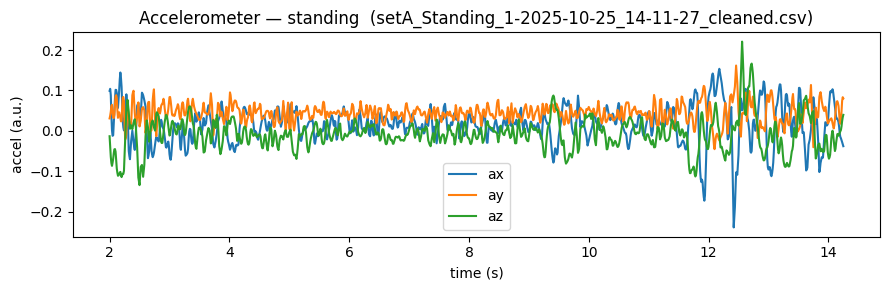

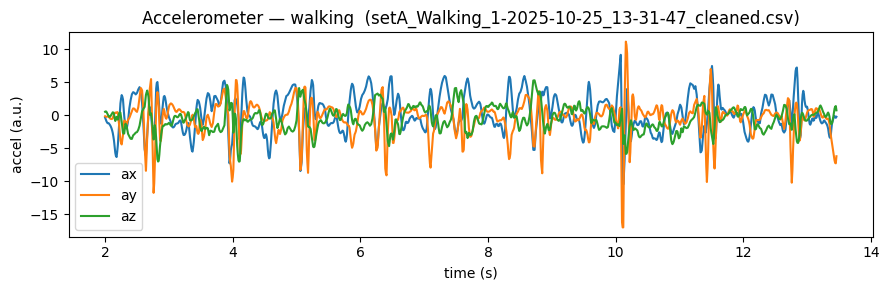

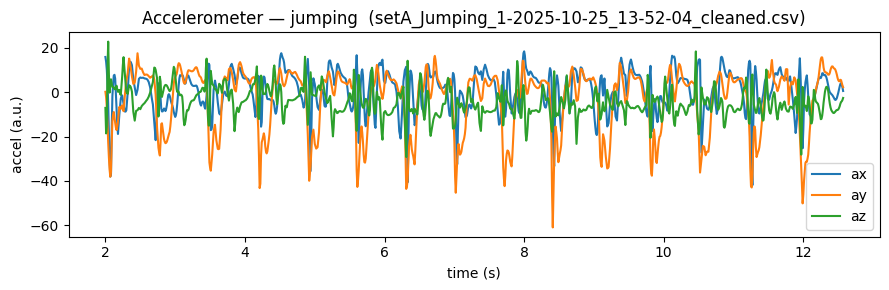

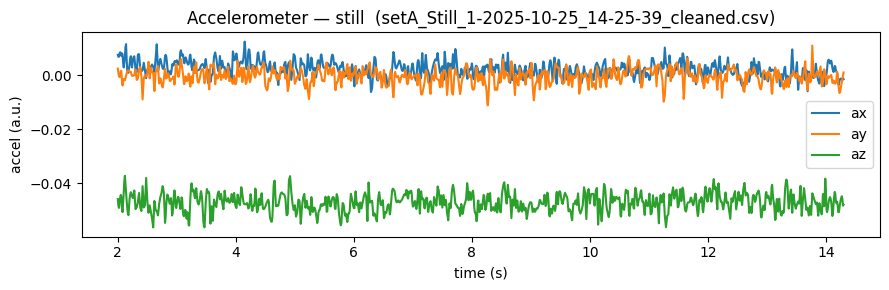

In [14]:
picked = {}
for p in clean_train:
    _, act = read_split_activity(p)
    if act not in picked:
        picked[act] = p
    if len(picked) == 4:
        break

# plot ax/ay/az for each picked file
order = ["standing", "walking", "jumping", "still"]
for act in order:
    if act in picked:
        df = pd.read_csv(picked[act], usecols=["time_s","ax","ay","az"])
        plt.figure(figsize=(9,3))
        plt.plot(df["time_s"], df["ax"], label="ax")
        plt.plot(df["time_s"], df["ay"], label="ay")
        plt.plot(df["time_s"], df["az"], label="az")
        plt.title(f"Accelerometer — {act}  ({os.path.basename(picked[act])})")
        plt.xlabel("time (s)"); plt.ylabel("accel (a.u.)")
        plt.legend(); plt.tight_layout(); plt.show()


**Observations — Accelerometer (per activity)**

- **Standing**  
  - Very low variance across all axes as expected.  
  - Small spikes around 12–13 s likely from handling/stance adjustment rather than the activity itself.

- **Walking**  
  - Clear rhythmic oscillations with fairly regular peaks/troughs (≈ step cadence).  
  - Amplitudes are moderate and fairly symmetric across axes, consistent with steady gait.

- **Jumping**  
  - High-amplitude, short-duration impulses aligned with take-off/landing phases.  
  - Distinct negative/positive swings (especially on one axis), separating it well from walking.

- **Still**  
  - Near-flat traces with tiny sensor noise; one axis shows a constant offset (gravity component due to phone orientation).  
  - No visible periodicity or drift.

**Takeaway.** The class signatures are well separated: *still/standing* are low-variance baselines, *walking* shows stable periodicity (good for frequency features), and *jumping* exhibits sparse, large impulses (good for peak/energy features).```


### 3.4 — Raw signal (gyroscope) — one example per activity (train)
We visualize **gx/gy/gz** for one representative **train** recording per activity to inspect rotational motion patterns.


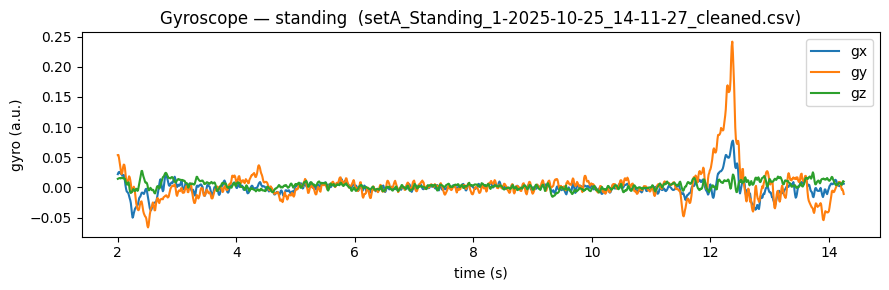

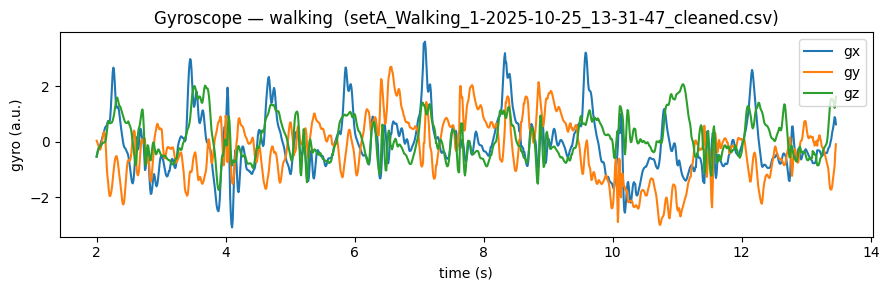

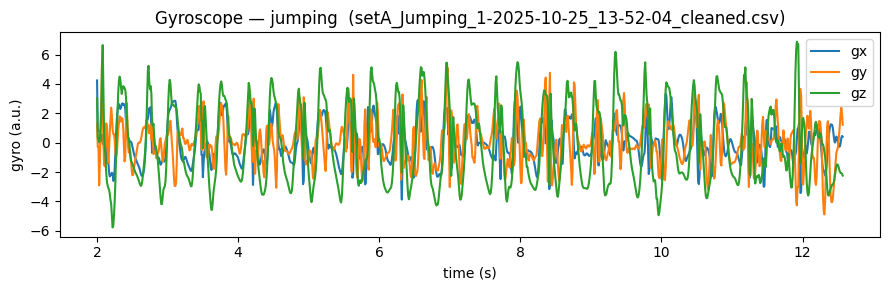

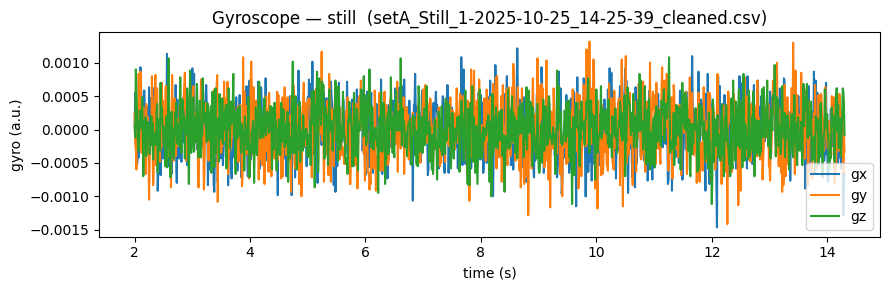

In [15]:
if 'picked' not in globals() or not picked:
    picked = {}
    for p in clean_train:
        _, act = read_split_activity(p)
        if act not in picked:
            picked[act] = p
        if len(picked) == 4:
            break

order = ["standing", "walking", "jumping", "still"]
for act in order:
    if act in picked:
        df = pd.read_csv(picked[act], usecols=["time_s","gx","gy","gz"])
        plt.figure(figsize=(9,3))
        plt.plot(df["time_s"], df["gx"], label="gx")
        plt.plot(df["time_s"], df["gy"], label="gy")
        plt.plot(df["time_s"], df["gz"], label="gz")
        plt.title(f"Gyroscope — {act}  ({os.path.basename(picked[act])})")
        plt.xlabel("time (s)"); plt.ylabel("gyro (a.u.)")
        plt.legend(); plt.tight_layout(); plt.show()


**Observations — Gyroscope (per activity)**

- **Standing**
  - Near-zero angular rates across axes (noise level).
  - Brief spike ~12 s suggests a handling/posture adjustment, not the activity.

- **Walking**
  - Clear periodic oscillations consistent with step cadence.
  - Rotational energy spread across axes, with occasional larger swings (turns/arm swing asymmetry).

- **Jumping**
  - High-amplitude, rapid oscillations clustered around take-off/landing.
  - Less regular than walking; short bursts with sharp peaks—good for short-window energy features.

- **Still**
  - Flat baseline around zero with tiny jitter; no visible periodicity.

**Takeaway.** Gyro reinforces separability: *still/standing* ≈ low variance, *walking* shows stable periodic rotation (frequency cue), and *jumping* shows brief, high-energy bursts (impulse/energy cue). Combining accel + gyro should further reduce walking↔standing confusion.


### 3.5 — Window size & overlap choice
We’ll use **2.0 s windows** with **75% overlap**:
- Hop (step) = 2.0 × (1 − 0.75) = **0.5 s**
- At the harmonized **100 Hz**, that’s **200 samples/window** and **50 samples/hop**.

**Why this works**
- Typical walking cadence ≈ **1.5–2.5 Hz** ⇒ a 2 s window captures ~3–5 cycles (stable frequency cues).
- Overlap improves temporal continuity for HMM decoding without exploding data size.
- Shorter windows (<1 s) risk missing periodicity; much longer windows (>3 s) smear transitions.


In [17]:
# Parameters we will use in feature extraction
WINDOW_SECONDS = 2.0
OVERLAP = 0.75

hop_s = WINDOW_SECONDS * (1.0 - OVERLAP)
win_samples = int(TARGET_HZ * WINDOW_SECONDS)
hop_samples = int(TARGET_HZ * hop_s)

print(f"Window = {WINDOW_SECONDS:.1f}s  | Overlap = {OVERLAP*100:.0f}%")
print(f"Hop     = {hop_s:.2f}s          | {win_samples} samples/window, {hop_samples} samples/hop at {TARGET_HZ} Hz")

calc = []
for row in dur_df.to_dict("records"):
    dur = float(row["duration_s"])
    if dur < WINDOW_SECONDS:
        nwin = 0
    else:
        nwin = 1 + int((dur - WINDOW_SECONDS) / hop_s)
    calc.append({**row, "n_windows": nwin})

win_df = pd.DataFrame(calc)
display(win_df.head(8))

summary_win = (win_df
               .groupby(["split","activity"], as_index=False)
               .agg(n_files=("n_windows","size"),
                    win_median=("n_windows","median"),
                    win_min=("n_windows","min"),
                    win_max=("n_windows","max")))
display(summary_win.sort_values(["split","activity"]))


Window = 2.0s  | Overlap = 75%
Hop     = 0.50s          | 200 samples/window, 50 samples/hop at 100 Hz


,file,split,activity,duration_s,n_windows
0,setA_Jumping_1-2025-10-25_13-52-04_cleaned.csv,train,jumping,10.57,18
1,setA_Jumping_10-2025-10-25_14-00-15_cleaned.csv,train,jumping,16.34,29
2,setA_Jumping_11-2025-10-25_14-06-37_cleaned.csv,train,jumping,12.28,21
3,setA_Jumping_12-2025-10-25_14-05-59_cleaned.csv,train,jumping,17.04,31
4,setA_Jumping_13-2025-10-25_14-05-22_cleaned.csv,train,jumping,11.59,20
5,setA_Jumping_2-2025-10-25_13-52-34_cleaned.csv,train,jumping,12.34,21
6,setA_Jumping_3-2025-10-25_13-53-05_cleaned.csv,train,jumping,11.34,19
7,setA_Jumping_4-2025-10-25_13-54-12_cleaned.csv,train,jumping,11.13,19


,split,activity,n_files,win_median,win_min,win_max
0,test,jumping,3,19.0,18,21
1,test,standing,3,26.0,24,28
2,test,still,3,22.0,22,23
3,test,walking,3,24.0,22,28
4,train,jumping,13,20.0,17,31
5,train,standing,13,21.0,17,25
6,train,still,13,22.0,21,31
7,train,walking,13,22.0,19,28


**Observations — Windowing (2.0 s, 75% overlap)**

- **Per-recording yield:** Jumping examples shown produce **18–31 windows** each (durations ≈10.6–17.0 s).
- **Train split (medians):** jumping **20**, standing **21**, still **22**, walking **22** windows/recording.
- **Test split (medians):** standing **26**, walking **24**, still **22**, jumping **19** windows/recording.
- **Range:** All activities span ~**17–31** windows—no zeros, so every file contributes to training/evaluation.
- **Balance:** Window counts are fairly even across activities; test has slightly longer clips for standing/walking (hence higher medians).
- **Model readiness:** With ~**20–26** windows/recording, there’s ample data to estimate HMM emissions and transitions.
- **Note on overlap:** 75% overlap increases temporal continuity (good for Viterbi) but introduces correlation between adjacent windows—expected and acceptable for HMMs.
